[![Dataflowr](https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png)](https://dataflowr.github.io/website/)

# Predicting Engine Failure with RNN

In this practicals, the goal is to predict the failure of an engine. The training dataset is made of time series obtained from several sensors on the engine until failure. The test dataset is made of the start of these time series and a failure date.

We will build a simple RNN taking as input the multi-dimensional time serie characterizing the engine and learn its parameters to predict the time of failure at each instant. At the start, the best prediction without any input data should be the average of the failure times in the dataset and as more and more data is fed in the RNN, it should give a better and better estimate.

The dataset is provided by [NASA](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan), see also [Kaggle](https://www.kaggle.com/datasets/suriyachayatummagoon/cmapssdata?select=Damage+Propagation+Modeling.pdf)

In [1]:
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import gamma
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [2]:
torch.__version__

'1.13.1+cu116'

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


## 1. Downloading the data

This need to be done only once!

You can find the data on the website of the [NASA](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan) or on [Kaggle](https://www.kaggle.com/datasets/suriyachayatummagoon/cmapssdata?select=Damage+Propagation+Modeling.pdf) or on my website:

In [ ]:
%mkdir data
%cd data

In [ ]:
!wget 'https://www.di.ens.fr/~lelarge/CMAPSSData.zip'

In [ ]:
!unzip CMAPSSData.zip

In [ ]:
%cd ..

## 2. Loading the data

In [4]:
def get_CMAPSSData(nb_file):
    # get data from file and pre process it (normalization and convert to pandas)
    dataset_train = pd.read_csv('./data/train_FD00{}.txt'.format(nb_file),
                                sep=' ', header=None).drop([26, 27], axis=1)
    dataset_test = pd.read_csv('./data/test_FD00{}.txt'.format(nb_file),
                               sep=' ', header=None).drop([26, 27], axis=1)
    test_truth = pd.read_csv('./data/RUL_FD00{}.txt'.format(nb_file),
                             sep=' ', header=None).drop([1], axis=1)
    col_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8',
                 's9',
                 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
    dataset_train.columns = col_names
    dataset_test.columns = col_names
    test_truth.columns = ['more']
    test_truth['id'] = test_truth.index + 1
    rul = pd.DataFrame(dataset_test.groupby('id')['cycle'].max()).reset_index()
    rul.columns = ['id', 'max']
    test_truth['rtf'] = test_truth['more'] + rul['max']
    test_truth.drop('more', axis=1, inplace=True)
    dataset_test = dataset_test.merge(test_truth, on=['id'], how='left')
    dataset_test['ttf'] = dataset_test['rtf'] - dataset_test['cycle']
    dataset_test.drop('rtf', axis=1, inplace=True)
    dataset_train['ttf'] = dataset_train.groupby(['id'])['cycle'].transform(max) - dataset_train['cycle']
    features_col_name = ['setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8',
                         's9', 's10', 's11',
                         's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
    target_col_name = 'ttf'
    relevant_features_col_name = []
    for col in features_col_name:
        if not (len(dataset_train[col].unique()) == 1):
            relevant_features_col_name.append(col)
    sc = MinMaxScaler()
    dataset_train[features_col_name] = sc.fit_transform(dataset_train[features_col_name])
    dataset_test[features_col_name] = sc.transform(dataset_test[features_col_name])
    return dataset_train, dataset_test, relevant_features_col_name, target_col_name


def to_lists_of_tensors(dataset, features_col_name, target_col_name):
    # take pandas df and convert it to list of tensors (for pytorch)
    X, y = [], []
    nb_sequences = max(dataset['id'])
    for i in range(1, nb_sequences + 1):
        df_zeros = dataset.loc[dataset['id'] == i]
        df_one_x = df_zeros[features_col_name]
        df_one_y = df_zeros[target_col_name]
        X.append(torch.from_numpy(np.expand_dims(df_one_x.values, 1)).type(torch.FloatTensor))
        y.append(torch.from_numpy(df_one_y.values).type(torch.FloatTensor))
    return X, y


def convert_train_and_test_to_appropriate_format(dataset_train, dataset_test, features_col_name, target_col_name):
    # take 2 datasets (train and test and covert them to lists of tensors)
    X_train, y_train = to_lists_of_tensors(dataset_train, features_col_name, target_col_name)
    X_test, y_test = to_lists_of_tensors(dataset_test, features_col_name, target_col_name)
    return X_train, y_train, X_test, y_test


In [5]:
%pycat ./data/readme.txt

In [6]:
dataset_train, dataset_test, features_col_name, target_col_name = get_CMAPSSData(1)
X_train, y_train, X_test, y_test = convert_train_and_test_to_appropriate_format(dataset_train, dataset_test,
                                                                                    features_col_name, target_col_name)

In [7]:
dataset_train.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,ttf
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.205882,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.279412,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.220588,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.294118,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.235294,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187


Here I have done the minimal preprocessing of the data using the [`MinMaxScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) of sklearn to scale each feature in (0,1).

`X_train` is a list where each element is of shape (length_of_sequence,1,number_of_sensors) where the second dimension with value 1 corresponds to the batch size. As in the course, we will not proceed sequences by batches but one after the other.

In [8]:
X_train[0].shape

torch.Size([192, 1, 17])

## 3. WTTE-RNN model

Here, we follow an approach inspired from this [blog](https://ragulpr.github.io/2016/12/22/WTTE-RNN-Hackless-churn-modeling/#wtte-rnn-produces-risk-embeddings).

You first need to define a GRU (or LSTM) that will take as input a sequence of shape (length_of_sequence,1,number_of_sensors) and output a sequence of shape (length_of_sequence,2) obtained by passing the output of the GRU through a linear layer. As we want positive number, you will take the exponent.

In [9]:
class GRUnet(nn.Module):
    def __init__(self, dim_input, num_layers, dim_hidden, dim_output=2):
        super(GRUnet, self).__init__()
        #
        # your code here
        #
        self.gru = nn.GRU(input_size = dim_input,
                          hidden_size = dim_hidden, num_layers = num_layers)
        self.hidden_to_two = nn.Linear(dim_hidden, dim_output)
        

    def forward(self, x):
        #
        # your code here
        #
        gru_output, _ = self.gru(x)
        gru_output = gru_output.squeeze(1)
        two_output = self.hidden_to_two(gru_output)
        return torch.exp(two_output)

Test your network

In [10]:
model = GRUnet(dim_input=len(features_col_name), num_layers=3, dim_hidden=50)
model = model.to(device)

In [11]:
output = model(X_train[0].to(device))

In [12]:
output.shape

torch.Size([192, 2])

In order to learn the parameters of your RNN, you need to specify a loss and we will here follow a standard approach in reliability theory: we model the failure time as a [Weibull random variable](http://reliawiki.org/index.php/The_Weibull_Distribution)

$$
\mathbb{P}(X>t) = \exp\left( \frac{t}{\eta}\right)^{\beta},
$$
where $\eta$ is the scale parameter and $\beta$ is the shape parameter.

Note that we have for the mean of a Weibull distribution:
$$
\mathbb{E}[X] = \eta \Gamma(1+1/\beta),
$$
where $\Gamma$ is the [Gamma function](https://en.wikipedia.org/wiki/Gamma_function).

In our case, we will interpret the 2 outputs of the RNN as estimates for the parameters $\eta$ and $\beta$. In order to design a loss, we compute the log-likelihood:
\begin{eqnarray*}
\log f(t) &=& \log\left( \frac{\beta}{\eta}\right) +(\beta -1)\log\left(\frac{t}{\eta}\right) -\left(\frac{t}
{\eta} \right)^{\beta}\\
&=& \log \beta +\beta \log\left(\frac{t}{\eta}\right) -\log t-\left(\frac{t}
{\eta} \right)^{\beta}
\end{eqnarray*}

Define a loss function corresponding to the negative log-likelihood (add a small parameter $\epsilon$ to $t$ in order not to compute $\log 0$).

In [13]:
class weibull_loss(nn.Module):
    def __init__(self):
        super(weibull_loss, self).__init__()
        self.epsilon = 1e-6

    def forward(self, output, y):
        #
        # your code here
        #
        ya = (y + self.epsilon) / (output[:, 0])
        beta = output[:, 1]
        likelihoods = torch.log(beta) + beta* torch.log(ya) - torch.log(y+self.epsilon)- ya ** beta
        return -likelihoods.mean()

Test your loss function.

In [14]:
loss_fn = weibull_loss()
loss_fn(output.squeeze(),y_train[0].to(device))

tensor(73.4154, device='cuda:0', grad_fn=<NegBackward0>)

## 4. Training your model

Code your taining and testing loops.

You might want to use a scheduler like `torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=1, verbose='True',threshold=0.001)`

In [15]:
def train_epoch(X_train, y_train, model, loss_fn, optimizer, device):
    # train the model through the whole training dataset for one epoch
    # return the corresponding loss on the epoch
    #
    # your code here
    #
    nb_train_sequences = len(y_train)
    model.train()
    losses = []
    for k in range(nb_train_sequences):
        X, y = X_train[k], y_train[k]
        pred = model(X.to(device))
        loss = loss_fn(pred.squeeze(), y.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return np.mean(losses)


def test_epoch(X_test, y_test, model, loss_fn, device):
    # evaluate the model through the whole testing dataset
    # return the corresponding loss
    #
    # your code here
    #
    nb_test_sequences = len(y_test)
    model.eval()
    losses = []
    for k in range(nb_test_sequences):
        X, y = X_test[k], y_test[k]
        pred = model(X.to(device))
        loss = loss_fn(pred.squeeze(), y.to(device))
        losses.append(loss.item())
    return np.mean(losses)


def fit(model, X_train, y_train, X_test, y_test, optimizer, loss_fn, nb_epochs, device):
    # fit the model by training it nb_epochs times
    # you might want to use a scheduler
    #
    # your code here
    #
    train_loss_t = []
    test_loss_t = []
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=1, verbose='True',
                                                           threshold=0.001)
    for epoch in range(0, nb_epochs):
        message1 = 'Epoch: {}/{}'.format(epoch + 1, nb_epochs)
        print(message1)
        train_loss = train_epoch(X_train, y_train, model, loss_fn, optimizer,device)
        test_loss = test_epoch(X_test, y_test, model, loss_fn,device)
        message2 = 'Train set: Average loss: {:.4f}\n'.format(train_loss)
        message3 = 'Test set: Average loss: {:.4f} - Learning rate : {:.4f}\n'.format(test_loss,optimizer.param_groups[0]['lr'])
        scheduler.step(test_loss)
        train_loss_t.append(train_loss)
        test_loss_t.append(test_loss)
        print(message2)
        print(message3)
    return model, train_loss_t, test_loss_t

In [16]:
model = GRUnet(dim_input=len(features_col_name), num_layers=3, dim_hidden=50,dim_output=2)
model = model.to(device)

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = weibull_loss()
nb_epochs = 50

In [18]:
model, train_loss_t, test_loss_t = fit(model, X_train, y_train, X_test, y_test, optimizer, loss_fn, nb_epochs,device)

Epoch: 1/50
Train set: Average loss: 7.7127

Test set: Average loss: 6.3538 - Learning rate : 0.0100

Epoch: 2/50
Train set: Average loss: 5.5885

Test set: Average loss: 5.7347 - Learning rate : 0.0100

Epoch: 3/50
Train set: Average loss: 5.4834

Test set: Average loss: 5.6368 - Learning rate : 0.0100

Epoch: 4/50
Train set: Average loss: 5.4517

Test set: Average loss: 6.6789 - Learning rate : 0.0100

Epoch: 5/50
Epoch 00005: reducing learning rate of group 0 to 5.0000e-03.
Train set: Average loss: 5.8083

Test set: Average loss: 5.6405 - Learning rate : 0.0100

Epoch: 6/50
Train set: Average loss: 5.4304

Test set: Average loss: 5.6315 - Learning rate : 0.0050

Epoch: 7/50
Train set: Average loss: 5.3864

Test set: Average loss: 5.4625 - Learning rate : 0.0050

Epoch: 8/50
Train set: Average loss: 5.2771

Test set: Average loss: 5.3146 - Learning rate : 0.0050

Epoch: 9/50
Train set: Average loss: 5.1894

Test set: Average loss: 5.3211 - Learning rate : 0.0050

Epoch: 10/50
Epoch 0

In [19]:
def plot_losses(train_loss_t, test_loss_t):
    nb_epochs = len(train_loss_t)
    plt.plot(range(nb_epochs), train_loss_t, color='orange', label='Loss on the training set')
    plt.plot(range(nb_epochs), test_loss_t, color='green', label='Loss on the testing set')
    plt.legend()
    plt.show()

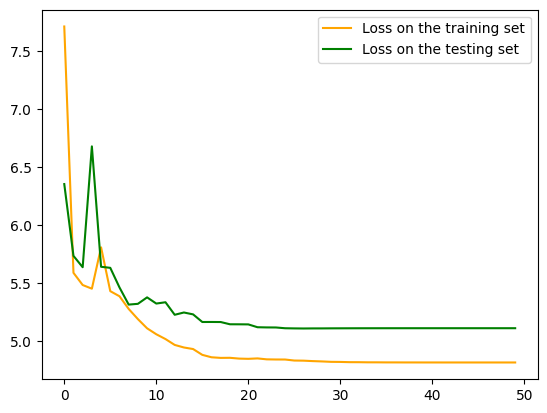

In [20]:
plot_losses(train_loss_t, test_loss_t)

## 5. Looking at your results

To compute a baseline, I am computing the average of all failure times in the train dataset.

In [21]:
max_val = np.zeros(len(y_train))
for i,y in enumerate(y_train):
    max_val[i] = y[0].item()
baseline = np.mean(max_val)

Here I am computing all the predictions made by my model on the test set and exporting these into `numpy`.

In [22]:
def compute_np(model,X_test, y_test,baseline=baseline,device=device,max_size=303):
    n_test = len(X_test)
    all_pred = np.empty((n_test,max_size,2))
    all_y = np.empty((n_test,max_size))
    base_pred = np.empty((n_test,max_size))
    all_pred[:] = np.NaN
    all_y[:] = np.NaN
    base_pred[:] = np.NaN
    list_npred = []
    for k in range(n_test):
        pred = model(X_test[k].to(device))
        pred_np = pred.cpu().detach().numpy()
        n_pred = pred_np.shape[0]
        list_npred.append(n_pred)
        all_pred[k,:n_pred,:] = pred_np
        all_y[k,:n_pred] = y_test[k].numpy()
        base_pred[k,:n_pred] = baseline - range(n_pred)
    return all_pred, all_y, base_pred, list_npred

In [23]:
all_pred, all_y, base_pred, list_npred = compute_np(model, X_test,y_test)
pred_fail = all_pred[:,:,0]*gamma(1+1/all_pred[:,:,1])

On the test set, we have only access to the start of the sequence and need to predict the failure time. For a given engine, you can compare the predictions made by the model, the baseline and the true value:

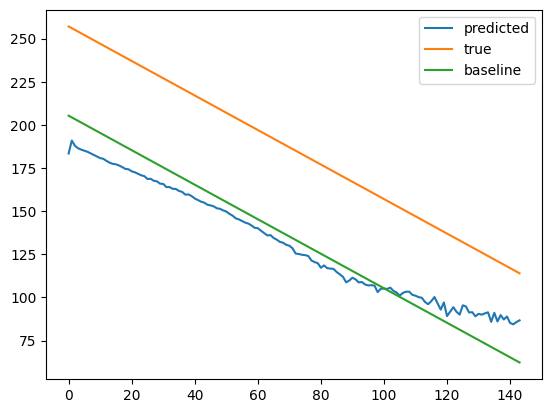

In [24]:
k = 50
plt.plot(pred_fail[k,:],label='predicted')
plt.plot(all_y[k],label='true')
plt.plot(base_pred[k],label='baseline')
plt.legend()

To get a measure of perfomance, we compute the RMSE: 

In [25]:
def RMSE(pred_fail, all_y):
    return np.sqrt((pred_fail-all_y)**2)

In [26]:
res= RMSE(pred_fail,all_y)
res_base = RMSE(base_pred,all_y)

The RMSE error is the distance between the esimation and the true line above. It is constant for the baseline and should decrease as we get more and more data with our model. Here is an example on the particular exmaple above:

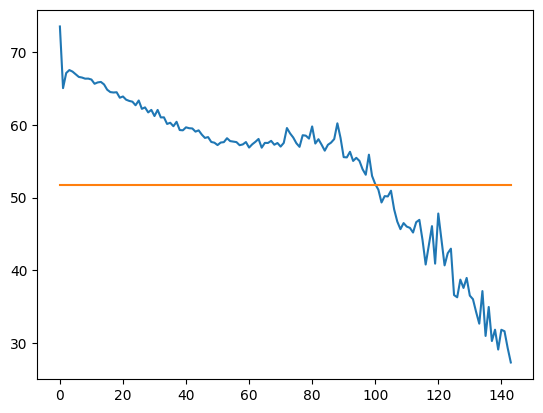

In [27]:
plt.plot(res[k])
plt.plot(res_base[k])

Below, I am averaging the RMSE over the dataset keeping the time axis (note that each point is an average but not with the same number of samples).

We see that the RMSE of the baseline is very bad for long sequences. This should be expected as these long sequences corresponds to healthy engines!

To the contrary, our model get a decreasing RMSE as a function of the length of the input sequence.

![](https://raw.githubusercontent.com/mlelarge/dataflowr/master/PlutonAI/img/rmse.png)

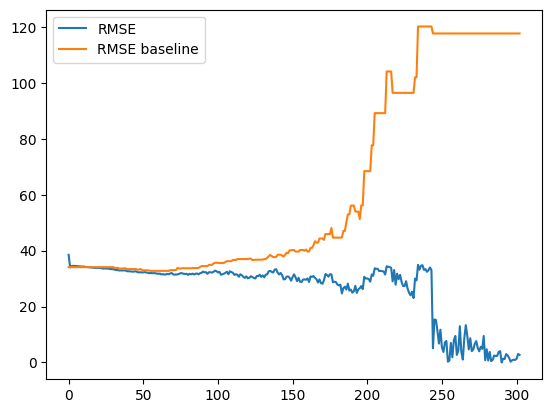

In [28]:
plt.plot(np.nanmean(res,0), label = 'RMSE')
plt.plot(np.nanmean(res_base,0), label ='RMSE baseline')
plt.legend()

In [29]:
np.nanmean(res)

32.055213042642514

In [30]:
np.nanmean(res_base)

36.534097434331095

In [31]:
last_indices = list((~np.isnan(res)).sum(axis = 1) - 1)

In [32]:
np.mean([res[i,j] for i,j in enumerate(last_indices)])

20.554718994108086

In [33]:
np.mean([res_base[i,j] for i,j in enumerate(last_indices)])

34.1034

Above we see that we divided the RMSE by more than 2 compare to the baseline.

Here we do a scatter plot of the predicitions vs true values for the baseline method (closer to the diagonal in blue is better):

![](https://raw.githubusercontent.com/mlelarge/dataflowr/master/PlutonAI/img/base_scatter.png)

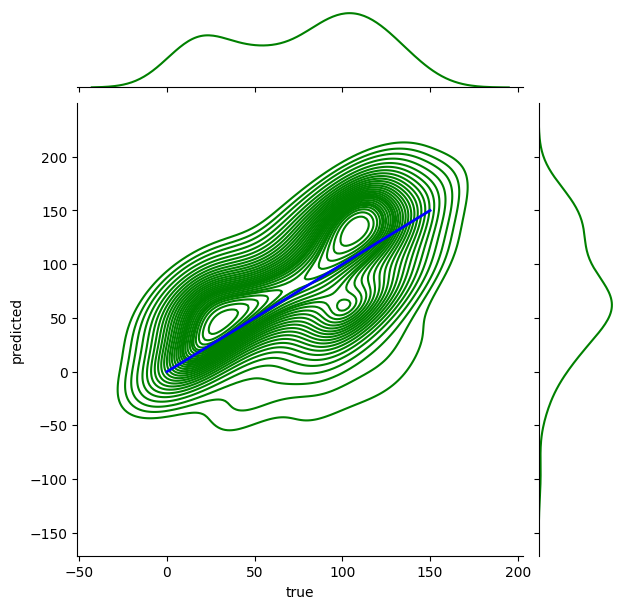

In [34]:
plot = sns.jointplot(x=[all_y[i,j] for i,j in enumerate(last_indices)],y=[base_pred[i,j] for i,j in enumerate(last_indices)],dropna=True,kind="kde", n_levels=30, color="g");
plot.ax_joint.plot([0,150], [0,150], 'b-', linewidth = 2);
plot.set_axis_labels('true', 'predicted');

Now we do the same scatter plot with our model (colser to the diagonal in blue is better). We see a great improvement.

![](https://raw.githubusercontent.com/mlelarge/dataflowr/master/PlutonAI/img/model_scatter.png)

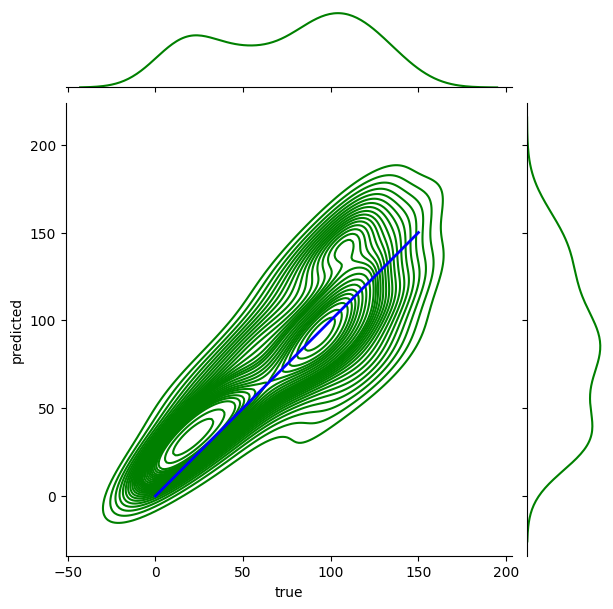

In [35]:
plot = sns.jointplot(x=[all_y[i,j] for i,j in enumerate(last_indices)],y=[pred_fail[i,j] for i,j in enumerate(last_indices)],dropna=True,kind="kde", n_levels=30, color="g");
plot.ax_joint.plot([0,150], [0,150], 'b-', linewidth = 2);
plot.set_axis_labels('true', 'predicted');

[![Dataflowr](https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png)](https://dataflowr.github.io/website/)